## Preprocessing Data

In [1]:
# import os
# import shutil
# import glob

# # we have 25k images
# len(os.listdir('train'))

# # Problem is all are in same directory and we will create separate folders for each category
# os.mkdir('cat')

# os.listdir('train')[1]

# # Moving cat images to cat directory
# for image in glob.glob('train/c*.jpg'):
#     shutil.move(image, 'cat')

# # Renaming train as dog as it contains only dog images
# os.rename('train', 'dog')



# # all the data now in data folder containing cat and dog directory(* manually moved both folders to data)


# checking format for submission
import pandas as pd 
df = pd.read_csv('sampleSubmission.csv')
df.head()

,id,label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os,time
tf.__version__

'2.4.0'

In [3]:
# tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[]

In [4]:
train_data_dir = 'data'
BATCH_SIZE = 16
IMAGE_SIZE = (128,128)

In [5]:
train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.1)
train_data = train_gen.flow_from_directory(train_data_dir, class_mode='binary',
                                           target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, subset='training')

validation_data = train_gen.flow_from_directory(train_data_dir, class_mode='binary',
                                                target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, subset='validation')

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [6]:
train_data.class_indices

{'cat': 0, 'dog': 1}

In [7]:
input_shape = (128,128,3)
EPOCHS = 20
earlystop = EarlyStopping(monitor='val_loss', patience=3 )

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=5, activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'),
    tf.keras.layers.Conv2D(filters=32,kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'),
    tf.keras.layers.Conv2D(filters=64,kernel_size=2, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 61, 61, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 59, 59, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        1

In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_data, epochs=EPOCHS,
                    validation_data=validation_data, callbacks=[earlystop])

In [ ]:
model.save('catvdog.h5')

In [11]:
def load_preprocess(image_path):
    
    im = Image.open(image_path)
    
    # resizing image as 299x299 as inceptionNet accept this dimension
    im = im.resize((128,128))
    
    # converting image to numpy array
    # reshape to image to image compatible for model prediction
    # normalizing image input image array 
    im = np.array(im) \
        .reshape(-1, 128,128, 3) \
        .astype('float32')/255.
    return im

In [12]:
def make_pred(im_path, model):
    return "Dog" if model.predict(load_preprocess(im_path))[0][0] > 0.5 else  "Cat"  

In [13]:
loaded_model = tf.keras.models.load_model('catvdog.h5')

In [14]:
make_pred('test1/testing/228.jpg', loaded_model)

'Cat'

Dog


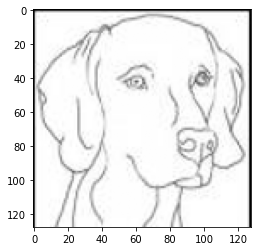

In [15]:
f_name = 'test1/testing/200.jpg'
print(make_pred(f_name, loaded_model))
plt.imshow(load_preprocess(f_name)[0])

In [ ]:
current = time.time()
idx = []
label = []

for x, image in enumerate(os.listdir('test1/testing')):
    idx.append(os.path.splitext(image)[0])
    label.append(make_pred('test1/testing/'+image, loaded_model))
print(f'Time taken in predictions: {time.time()-current}')

In [ ]:
df = pd.DataFrame({'id':idx, 'label':label})
df['label'] = df['label'].map({'Dog':1, 'Cat':0})
df['id'] = df.id.apply(lambda x: int(x))
df = df.sort_values(by='id', ignore_index=True)


In [ ]:
# Exporting DataFrame as csv for submission
df.to_csv('submission.csv', index=False)